In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Simple coordinate reader for xyz files. Will run for single structure xyz files and trajectories.

def read_coordinate(xyz_file, atom_list):

    with open(xyz_file, 'r') as file:
        lines = file.readlines()
        no_atoms = int(lines[0])
        coordinate_list = []
        
        i = 0
        
        while i != len(lines):
            segment = lines[i:i+no_atoms+2][2:]
            segment = [line.split()[1:4] for line in segment]
            coordinate_list.append(np.array(segment).astype(float))
            
            i = i + no_atoms + 2
            
        file.close()
        
    def read_distances(coordinate_list, atom1,atom2):

        distances = []

        for n in range(len(coordinate_list)):
            dX = coordinate_list[n][atom1 - 1][0] - coordinate_list[n][atom2 - 1][0]
            dY = coordinate_list[n][atom1 - 1][1] - coordinate_list[n][atom2 - 1][1]
            dZ = coordinate_list[n][atom1 - 1][2] - coordinate_list[n][atom2 - 1][2]

            d = np.sqrt(dX**2 + dY**2 + dZ**2)

            d = float("{:.5f}".format(d)) # Round to 5 decimal places (Matches GaussView)

            distances.append(d)

        return distances

    def read_angles(coordinate_list, atom1, atom2, atom3):

        rad2deg_ = 180 / np.pi
        angles = []

        for n in range(len(coordinate_list)): 

            x1 = coordinate_list[n][atom1 - 1][0] - coordinate_list[n][atom2 - 1][0]
            y1 = coordinate_list[n][atom1 - 1][1] - coordinate_list[n][atom2 - 1][1]
            z1 = coordinate_list[n][atom1 - 1][2] - coordinate_list[n][atom2 - 1][2]

            x2 = coordinate_list[n][atom3 - 1][0] - coordinate_list[n][atom2 - 1][0]
            y2 = coordinate_list[n][atom3 - 1][1] - coordinate_list[n][atom2 - 1][1]
            z2 = coordinate_list[n][atom3 - 1][2] - coordinate_list[n][atom2 - 1][2]

            dot = (x1 * x2) + (y1 * y2) + (z1 * z2)

            mag1 = np.sqrt(x1**2 + y1**2 + z1**2)
            mag2 = np.sqrt(x2**2 + y2**2 + z2**2)

            angle = np.arccos(dot / (mag1 * mag2)) * rad2deg_
            angle = float("{:.5f}".format(angle))

            angles.append(angle)

        return angles

    def read_dihedrals(coordinate_list, atom1, atom2, atom3, atom4):

        dihedrals = []

        for n in range(len(coordinate_list)):     

            A = coordinate_list[n][atom1 - 1]
            B = coordinate_list[n][atom2 - 1]
            C = coordinate_list[n][atom3 - 1]
            D = coordinate_list[n][atom4 - 1]

            AB = B - A
            BC = C - B
            CD = D - C

            N1 = np.cross(AB, BC)
            N2 = np.cross(BC, CD)

            N1 /= np.linalg.norm(N1)
            N2 /= np.linalg.norm(N2)

            cos_theta = np.dot(N1, N2)
            angle = np.arccos(cos_theta)

            m = np.cross(N1, N2)
            sign = np.dot(m, BC / np.linalg.norm(BC))
            if sign < 0:
                angle = -angle

            angle_degrees = float("{:.5f}".format(np.degrees(angle)))

            dihedrals.append(angle_degrees)

        return dihedrals
    
    if len(atom_list) == 1:
        
        positions = []
        
        for n in range(len(coordinate_list)):
            
            x = tuple([coordinate_list[n][atom_list[0] - 1][0], coordinate_list[n][atom_list[0] - 1][1], coordinate_list[n][atom_list[0] - 1][2]])
            positions.append(x)
            
        return positions
    
    if len(atom_list) == 2:
        return read_distances(coordinate_list, atom_list[0], atom_list[1])
    
    if len(atom_list) == 3:
        return read_angles(coordinate_list, atom_list[0], atom_list[1], atom_list[2])
    
    if len(atom_list) == 4:
        return read_dihedrals(coordinate_list, atom_list[0], atom_list[1], atom_list[2], atom_list[3])
    
    if len(atom_list) > 4:
        raise ValueError('You have specified too many atoms')
    

169.4905990552378

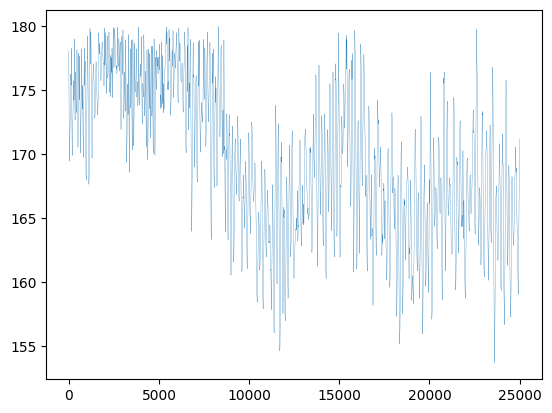

In [28]:
colvar = read_coordinate('sample_data/nN_scale_uniaxial/1nN.xyz', [8, 7, 16])

plt.plot(range(len(colvar)), colvar, linewidth=0.2)
np.average(colvar)


(array([ 18.,   9.,  25.,  21.,  33.,  36.,  93.,  73., 111., 155., 206.,
        229., 258., 301., 308., 460., 463., 484., 500., 520., 528., 583.,
        577., 558., 622., 530., 462., 426., 452., 421., 406., 347., 335.,
        288., 289., 205., 150., 145., 137., 185., 189., 135.,  78.,  57.,
         39.,  29.,  24.]),
 array([153.68986   , 154.24425362, 154.79864723, 155.35304085,
        155.90743447, 156.46182809, 157.0162217 , 157.57061532,
        158.12500894, 158.67940255, 159.23379617, 159.78818979,
        160.3425834 , 160.89697702, 161.45137064, 162.00576426,
        162.56015787, 163.11455149, 163.66894511, 164.22333872,
        164.77773234, 165.33212596, 165.88651957, 166.44091319,
        166.99530681, 167.54970043, 168.10409404, 168.65848766,
        169.21288128, 169.76727489, 170.32166851, 170.87606213,
        171.43045574, 171.98484936, 172.53924298, 173.0936366 ,
        173.64803021, 174.20242383, 174.75681745, 175.31121106,
        175.86560468, 176.4199983 , 

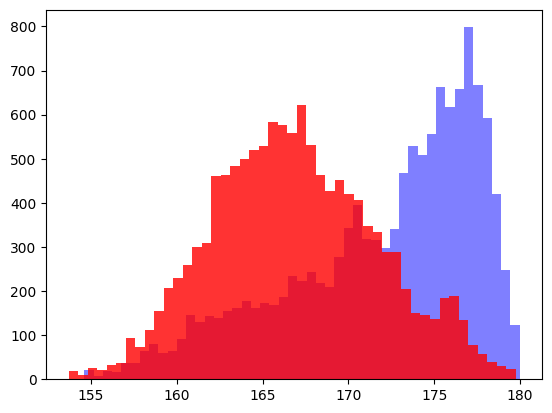

In [31]:
midpt = int(np.round(len(colvar) / 2))

fig, ax = plt.subplots()
ax.hist(colvar[0:midpt], bins='rice', fc=(0, 0, 1, 0.5)) # First half shown in blue
ax.hist(colvar[midpt:-1], bins='rice', fc=(1, 0, 0, 0.8)) # Second half shown in red